In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Some constants

In [2]:
O = np.array([0.0, 0.0, 0.0])
X = np.array([1.0, 0.0, 0.0])
Y = np.array([0.0, 1.0, 0.0])
Z = np.array([0.0, 0.0, 1.0])

## Coil class structure

In [3]:
class Coil():
    def __init__(self, c, n, ID, OD, L, IN,
                 axial_mesh_count = 18,
                 longitudinal_mesh_count = 2,
                 radial_mesh_count = 2):
        self.n = n # normal vector [1]
        self.c = c # center vector [m]
        if np.dot(self.n, X) < 0.5:
            self.u = np.cross(self.n, X)
        else:
            self.u = np.cross(self.n, Y)
        self.v = np.cross(self.n, self.u)
        self.ID = ID # inner diameter [m]
        self.OD = OD # outer diameter [m]
        self.IN = IN # current-turns [A]
        self.L = L # length [m]
        self.axial_mesh_count = axial_mesh_count # along 360 degree circumference
        self.radial_mesh_count = radial_mesh_count # along radial direction from ID to OD
        self.longitudinal_mesh_count = longitudinal_mesh_count # along length from -L/2 to +L/2

    def __repr__(self):
        return "<Coil ID:%s OD:%s L:%s IN:%s>" % (self.ID, self.OD, self.L, self.IN)

    def __str__(self):
        return "Coil with ID %s m, OD %s m, L %s m, IN %s A-turns\n \
                position %s, normal %s" % (self.ID, self.OD, self.L, self.IN, self.r, self.n)

## Field of single coil

The following Biot-Savart routine could certainly be improved in terms of speed. We'll get to that when needed.

"Premature optimization is the root of all evil." (Donald Knuth)

In [4]:
def field_single_coil(point, coil):
    B = np.zeros_like(point)
    for theta in np.linspace(0.0, 2.0 * math.pi, coil.axial_mesh_count):
        for r in np.linspace(coil.ID/2.0, coil.OD/2.0, coil.radial_mesh_count):
            for z in np.linspace(-coil.L/2.0, +coil.L/2.0, coil.longitudinal_mesh_count):
                source = coil.c + z * coil.n + r * coil.u * np.cos(theta) + r * coil.v * np.sin(theta)
                diff = point - source
                delta = 2.0 * math.pi * r * (-coil.u * np.sin(theta) + coil.v * np.cos(theta))
                B += np.cross(delta, diff) / np.power(np.linalg.norm(diff, axis = -1), 3)
                # FIXME the (n,3) / (n,) norm doesn't like to get n points as ndarray, broadcast error
    B /= coil.axial_mesh_count * coil.radial_mesh_count * coil.longitudinal_mesh_count
    B *= 1e-7 * coil.IN # mu0/4pi is just 1e-7
    return B

For on-axis calculations, the axial mesh count doesn't seem to matter that much. For non-negligible longitudinal extent (L) the longitudinal mesh count matters.

## Field of list of coils

In [5]:
def field(point, coils):
    B = np.zeros_like(point)
    for coil in coils:
        B += field_single_coil(point,coil)
    return B

## Define single coil

In [6]:
main_coil_1 = Coil(np.array([0.0, 0.0, 0.05]),
                   np.array([0.0, 0.0, 1.0]),
                   ID = 0.18, OD = 0.20, L = 0.10, IN = 300.2e3,
                   longitudinal_mesh_count = 2,
                   radial_mesh_count = 2,
                   axial_mesh_count = 18)

print("B([0,0,0]) =", field_single_coil(O, main_coil_1), "T")

B([0,0,0]) = [ 9.43211884e-18 -1.89445698e-02  1.31907485e+00] T


Assess the uncertainty due to the discretization when cutting off the value. Here we just increase the uncertainty until we reach difference better than a cut-off.

In [7]:
# Test point half radius away from axis, two lenghts away from center
point = X * main_coil_1.ID / 2 + Z * 2 * main_coil_1.L
# Scale reference is magnitude at center of coil
B0 = np.linalg.norm(field_single_coil(O, main_coil_1))

main_coil_1.longitudinal_mesh_count = 12
main_coil_1.radial_mesh_count = 4
main_coil_1.axial_mesh_count = 30
Bprev = field_single_coil(point, main_coil_1)
for main_coil_1.longitudinal_mesh_count in range(1, 20, 2): 
    B = field_single_coil(point, main_coil_1)
    print("B(r) =", B, "T for longitudinal_mesh_count = ", main_coil_1.longitudinal_mesh_count, end = " ")
    if (np.linalg.norm(B - Bprev) < 0.001 * B0): print("delta < 0.1%")
    else: print()
    Bprev = B

main_coil_1.longitudinal_mesh_count = 12
main_coil_1.radial_mesh_count = 4
main_coil_1.axial_mesh_count = 30
Bprev = field_single_coil(point, main_coil_1)
for main_coil_1.radial_mesh_count in range(1, 10): 
    B = field_single_coil(point, main_coil_1)
    print("B(r) =", B, "T for radial_mesh_count = ", main_coil_1.radial_mesh_count, end = " ")
    if (np.linalg.norm(B - Bprev) < 0.001 * B0): print("delta < 0.1%")
    else: print()
    Bprev = B

main_coil_1.longitudinal_mesh_count = 12
main_coil_1.radial_mesh_count = 4
main_coil_1.axial_mesh_count = 30
Bprev = field_single_coil(point, main_coil_1)
for main_coil_1.axial_mesh_count in range(6, 36, 2): 
    B = field_single_coil(point, main_coil_1)
    print("B(r) =", B, "T for axial_mesh_count = ", main_coil_1.axial_mesh_count, end = " ")
    if (np.linalg.norm(B - Bprev) < 0.001 * B0): print("delta < 0.1%")
    else: print()
    Bprev = B

B(r) = [0.0630803  0.00874246 0.10743725] T for longitudinal_mesh_count =  1 
B(r) = [0.17109783 0.01114886 0.20302166] T for longitudinal_mesh_count =  3 
B(r) = [0.16116123 0.01120798 0.19721499] T for longitudinal_mesh_count =  5 
B(r) = [0.15785071 0.01122754 0.19527988] T for longitudinal_mesh_count =  7 
B(r) = [0.15620371 0.01123715 0.1943149 ] T for longitudinal_mesh_count =  9 
B(r) = [0.15521921 0.01124285 0.19373708] T for longitudinal_mesh_count =  11 delta < 0.1%
B(r) = [0.15456466 0.01124662 0.19335242] T for longitudinal_mesh_count =  13 delta < 0.1%
B(r) = [0.15409807 0.0112493  0.19307797] T for longitudinal_mesh_count =  15 delta < 0.1%
B(r) = [0.15374868 0.01125129 0.1928723 ] T for longitudinal_mesh_count =  17 delta < 0.1%
B(r) = [0.15347727 0.01125284 0.19271244] T for longitudinal_mesh_count =  19 delta < 0.1%
B(r) = [0.14628455 0.0110736  0.17535728] T for radial_mesh_count =  1 
B(r) = [0.15466322 0.01123622 0.19357145] T for radial_mesh_count =  2 
B(r) = [0.1

It seem that
```
longitudinal_mesh_count = 12
radial_mesh_count = 4
axial_mesh_count = 30
```
is a pretty good start.

In [8]:
main_coil_1.longitudinal_mesh_count = longitudinal_mesh_count = 12
main_coil_1.radial_mesh_count = radial_mesh_count = 4
main_coil_1.axial_mesh_count = axial_mesh_count = 30

Maybe now is a good time to look at a profile of the Biot-Savart function.

In [9]:
%timeit field_single_coil(point, main_coil_1)

104 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%prun -s cumulative field_single_coil(point, main_coil_1)

         114210 function calls in 0.138 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.138    0.138 {built-in method builtins.exec}
        1    0.000    0.000    0.138    0.138 <string>:1(<module>)
        1    0.043    0.043    0.138    0.138 <ipython-input-4-530a891857b1>:1(field_single_coil)
     1440    0.026    0.000    0.072    0.000 numeric.py:1701(cross)
     4320    0.013    0.000    0.040    0.000 numeric.py:1620(moveaxis)
     8640    0.014    0.000    0.021    0.000 numeric.py:1557(normalize_axis_tuple)
     1440    0.009    0.000    0.016    0.000 linalg.py:2293(norm)
      151    0.003    0.000    0.007    0.000 function_base.py:37(linspace)
     1591    0.006    0.000    0.006    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     8640    0.003    0.000    0.005    0.000 numeric.py:1607(<listcomp>)
    12960    0.004    0.000    0.004    0.000 {built-in method numpy.core

In [11]:
%load_ext line_profiler

In [12]:
%lprun -f field_single_coil field_single_coil(point, main_coil_1)

Timer unit: 1e-06 s

Total time: 0.191213 s
File: <ipython-input-4-530a891857b1>
Function: field_single_coil at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def field_single_coil(point, coil):
     2         1         37.0     37.0      0.0      B = np.zeros_like(point)
     3        31        171.0      5.5      0.1      for theta in np.linspace(0.0, 2.0 * math.pi, coil.axial_mesh_count):
     4       150       1719.0     11.5      0.9          for r in np.linspace(coil.ID/2.0, coil.OD/2.0, coil.radial_mesh_count):
     5      1560       8009.0      5.1      4.2              for z in np.linspace(-coil.L/2.0, +coil.L/2.0, coil.longitudinal_mesh_count):
     6      1440      18754.0     13.0      9.8                  source = coil.c + z * coil.n + r * coil.u * np.cos(theta) + r * coil.v * np.sin(theta)
     7      1440       2119.0      1.5      1.1                  diff = point - source
     8      1440      134

Before we start optimizing, here's what we should get.

In [13]:
field_single_coil(point, main_coil_1)

array([0.15486199, 0.01124491, 0.19352721])

In [14]:
eijk = np.zeros((3, 3, 3))
eijk[0, 1, 2] = eijk[1, 2, 0] = eijk[2, 0, 1] = 1
eijk[0, 2, 1] = eijk[2, 1, 0] = eijk[1, 0, 2] = -1

def field_single_coil(point, coil):
    B = np.zeros_like(point)
    space_theta = np.linspace(0.0, 2.0 * math.pi, coil.axial_mesh_count)
    space_r = np.linspace(coil.ID/2.0, coil.OD/2.0, coil.radial_mesh_count)
    space_z = np.linspace(-coil.L/2.0, +coil.L/2.0, coil.longitudinal_mesh_count)
    for theta in space_theta:
        u2 = coil.u * np.cos(theta) + coil.v * np.sin(theta)
        v2 = coil.v * np.cos(theta) - coil.u * np.sin(theta)
        for r in space_r:
            diffc = point - (coil.c + r * u2)
            deltal = 2.0 * math.pi * r * v2
            for z in space_z:
                diff = diffc - z * coil.n
                norm = np.einsum('i,i', diff, diff)
                norm = np.power(norm, 3/2)
                cross = np.einsum('ijk,j,k', eijk, deltal, diff)
                B += cross / norm
                # FIXME the (n,3) / (n,) norm doesn't like to get n points as ndarray, broadcast error
    B /= coil.axial_mesh_count * coil.radial_mesh_count * coil.longitudinal_mesh_count
    B *= 1e-7 * coil.IN # mu0/4pi is just 1e-7
    return B

In [15]:
field_single_coil(point, main_coil_1)

array([0.15486199, 0.01124491, 0.19352721])

In [16]:
%timeit field_single_coil(point, main_coil_1)

17.8 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%lprun -f field_single_coil field_single_coil(point, main_coil_1)

Timer unit: 1e-06 s

Total time: 0.034068 s
File: <ipython-input-14-b8403f97a64b>
Function: field_single_coil at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def field_single_coil(point, coil):
     6         1         31.0     31.0      0.1      B = np.zeros_like(point)
     7         1         91.0     91.0      0.3      space_theta = np.linspace(0.0, 2.0 * math.pi, coil.axial_mesh_count)
     8         1         52.0     52.0      0.2      space_r = np.linspace(coil.ID/2.0, coil.OD/2.0, coil.radial_mesh_count)
     9         1         50.0     50.0      0.1      space_z = np.linspace(-coil.L/2.0, +coil.L/2.0, coil.longitudinal_mesh_count)
    10        31         26.0      0.8      0.1      for theta in space_theta:
    11        30        239.0      8.0      0.7          u2 = coil.u * np.cos(theta) + coil.v * np.sin(theta)
    12        30        225.0      7.5      0.7          v2 = coil.v * np.cos(theta) -

## Define list of coils

This is the list of coil positions and current-turns in magnet design v6.

In [18]:
IN = np.array([300.2, 314.2, 297.4, 296.0, 292.4, 291.8, 284.4, 308.6, 306.9, 206.5, 200.9, 212.0, 312.5]) * 1e3
ID = np.array(8*[0.18] + 5*[0.34])
OD = ID + 0.02
L  = 0.10
y  = np.array(8*[0.0] + [-0.054, -0.020, 0.015, 0.050, 0.085])
z  = np.array([0.050, 0.155, 0.260, 0.365, 0.470, 0.575, 0.680, 0.785, 0.953, 1.060, 1.166, 1.272, 1.378])
th = np.radians(np.array(8*[0.0] + 5*[18.0]))

main_coils = [Coil(np.array([0.0, y, z]),
                   np.array([0.0, math.sin(th), math.cos(th)]),
                   ID = ID, OD = OD, L = L, IN = IN,
                   longitudinal_mesh_count = longitudinal_mesh_count,
                   radial_mesh_count = radial_mesh_count,
                   axial_mesh_count = axial_mesh_count)
              for IN, ID, OD, y, z, th in zip(IN, ID, OD, y, z, th)]

# Field of first coil at origin
print("B(0,0,0) =", field_single_coil(O, main_coils[0]), "T")
print("B(0,0,0) =", field(O, main_coils[0:1]), "T")

B(0,0,0) = [ 8.99614312e-17 -1.88567305e-02  1.36294241e+00] T
B(0,0,0) = [ 8.99614312e-17 -1.88567305e-02  1.36294241e+00] T


In [19]:
# Field of all coils at origin
print(field(O, main_coils), "T")

[ 6.65454491e-17 -5.96038808e-02  1.86135611e+00] T


## Calculate field on z and s axis

In [20]:
def plot_profile(main_coils, verbose = False):
    # Straight section
    z = np.linspace(0.00, 0.85, 86)
    Bz = np.array([field(np.array([0.0, 0.0, z]), main_coils) for z in z])
    # Angled section
    s = np.linspace(0.005, 0.545, 55)
    Bs = np.array([field(np.array([0.0, s * np.sin(np.radians(18)), 0.855 + s * np.cos(np.radians(18))]), main_coils) for s in s])
    
    # Plot blue in straight section, red in angled section
    fig, axs = plt.subplots(2, sharex = True)
    axs[0].plot(z, np.linalg.norm(Bz, axis = 1), '-b', 0.855+s, np.linalg.norm(Bs, axis = 1), '-r')
    axs[0].set_ylim(1.5, 4.0);
    axs[0].set_ylabel("|B| [T]");
    axs[1].plot(z[np.logical_and((z>0.2),(z<0.7))], np.linalg.norm(Bz - np.array([0.0,0.0,3.5]), axis = 1)[np.logical_and((z>0.2),(z<0.7))], '-b')
    axs[1].set_xlim(0.0, 1.4);
    axs[1].set_ylim(-0.10, +0.10);
    axs[1].set_xlabel("z < 0.855 [m] and s > 0.855 [m]");
    axs[1].set_ylabel("|B| [T]");
    
    # Print values
    if verbose:
        print(np.c_[z, np.linalg.norm(Bz, axis = 1)])
        print(np.c_[s, np.linalg.norm(Bs, axis = 1)])

This may take a while...

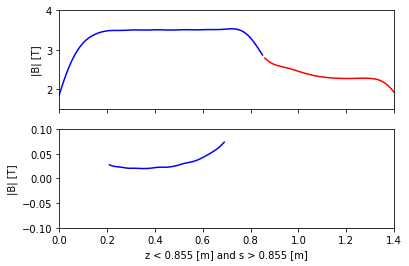

In [21]:
plot_profile(main_coils, verbose = False)

## Add trim coils

This is the definition of the trim coil geometry according to the magnet design v6. Currents are arbitrary and just intended to determine magnitude based on required 30 mT field.

In [22]:
IN = np.array(8*[25]) * 1e3
ID = np.array(8*[0.32])
OD = np.array(8*[0.34])
L  = 0.07
y  = np.array(8*[0.0])
z  = np.linspace(0.17, 0.73, 8)
th = np.radians(np.array(8*[0.0]))

trim_coils = [Coil(np.array([0.0, y, z]),
                   np.array([0.0, math.sin(th), math.cos(th)]),
                   ID = ID, OD = OD, L = L, IN = IN,
                   longitudinal_mesh_count = longitudinal_mesh_count,
                   radial_mesh_count = radial_mesh_count,
                   axial_mesh_count = axial_mesh_count)
              for IN, ID, OD, y, z, th in zip(IN, ID, OD, y, z, th)]

In [23]:
print("Bz =", field_single_coil(O, trim_coils[0])[2] / 1e-3, "mT")

Bz = 32.7964384038435 mT


Putting it all together with the main coils now.

In [24]:
coils = main_coils + trim_coils
print("Bz([0,0,0]) =", field(O, coils)[2], "T")

Bz([0,0,0]) = 1.9316851209721282 T


## Uniformity in trap region

Because we will be evaluating the field at a large number of points multiple times, it makes sense to cache the results and reuse them.

In [25]:
class Cache():
    def __init__(self, coils, space):
        ncoil = len(coils)
        (nz, nr, nth) = (len(space[0]), len(space[1]), len(space[2]))
        self.valid = np.zeros((ncoil,nz,nr,nth), dtype = np.int8)
        self.field = np.zeros((ncoil,nz,nr,nth,3), dtype = np.float)

    def __repr__(self):
        return "<Cache size:%s>" % (str(self.field.shape))

    def __str__(self):
        return "Coil with size %s" % (str(self.field.shape))

test_space = [np.linspace(0.20, 0.70, 51),
              np.linspace(0.00, 0.04, 3),
              np.linspace(0.0, 2.0*math.pi, 4)]

test_cache = Cache(coils, test_space)

In [26]:
def cached_field(point, index, coils, cache):
    (iz, ir, ith) = index
    field = np.zeros((1,3))
    for icoil, coil in enumerate(coils):
        if cache.valid[icoil, iz, ir, ith] == 0:
            IN = coil.IN
            coil.IN = 1
            # Store field for 1 A-turns
            cache.field[icoil, iz, ir, ith] = field_single_coil(point, coil)
            cache.valid[icoil, iz, ir, ith] = 1
            coil.IN = IN
        field += coil.IN * cache.field[icoil, iz, ir, ith]
    return field

First time requesting:

In [27]:
%%timeit -n 1 -r 1
cached_field(O, (0,0,0), coils, test_cache)

365 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Next times requesting:

In [28]:
%%timeit -n 20
cached_field(O, (0,0,0), coils, test_cache)

101 µs ± 8 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)


In [29]:
from timeit import default_timer as timer

def RMSE(space, coils, target, cache, verbose = False):
    SE = 0
    for iz, z in np.ndenumerate(space[0]):
        if verbose: print(round(z, 3), end = " ")
        start = timer()
        for ir, r in np.ndenumerate(space[1]):
            for ith, th in np.ndenumerate(space[2]):
                point = np.array([r * np.cos(th), r * np.sin(th), z])
                index = (iz, ir, ith)
                field = cached_field(point, index, coils, cache)
                SE += np.square(field[:,2] - target)
        end = timer()
        if verbose: print(round(end - start, 3), "s")
    MSE = SE / (len(space[0]) * len(space[1]) * len(space[2]))
    RMSE = np.sqrt(MSE)
    return RMSE / target

First time requesting:

In [30]:
%%timeit -n 1 -r 1
target = 3.5 # T
RMSE(test_space, coils, target, test_cache, verbose = False)

3min 31s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Next times requesting:

In [31]:
%%timeit -n 5
target = 3.5 # T
RMSE(test_space, coils, target, test_cache)

156 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Put all this in an objective function with parameters to optimize (i.e. coil current-turns).

In [32]:
def objective_RMSE(coils, verbose = False):
    # Define z, r, theta space to average over
    if not hasattr(objective_RMSE, "space"):
        objective_RMSE.space = [np.linspace(0.20, 0.70, 51),
                                np.linspace(0.0, 0.04, 3),
                                np.linspace(0.0, 2.0*math.pi, 4)]
    space = objective_RMSE.space

    # Create cache
    if not hasattr(objective_RMSE, "cache"):
        print("Creating cache...")
        objective_RMSE.cache = Cache(coils, space)
    if objective_RMSE.cache.field.shape != (len(coils), len(space[0]), len(space[1]), len(space[2]), 3):
        print("Recreating cache...")
        objective_RMSE.cache = Cache(coils, space)

    # Target value
    target = 3.5

    # Evaluate RMSE
    return np.linalg.norm(RMSE(space, coils, target, objective_RMSE.cache, verbose))

First time requesting:

In [33]:
%%timeit -n 1 -r 1
print(objective_RMSE(coils, verbose = False))

Creating cache...
0.09418850553224604
3min 32s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


That took a little while, so a note on scaling. At this point we are probably proportional to:
- 15 = number of coils (not just type of coils, but that's only a factor 5 difference between 3 and 15)
- 12 = longitudinal mesh count
- 4 = radial mesh count
- 30 = axial mesh count
- 51 = z grid size
- 3 = r grid size
- 4 = theta grid size

Think of the following number as the one that goes as $n$ inside the $\mathcal{O}(n)$.

In [34]:
scaling_factor = len(coils) * coils[0].longitudinal_mesh_count * coils[0].radial_mesh_count * coils[0].axial_mesh_count * len(objective_RMSE.space[0]) * len(objective_RMSE.space[1]) * len(objective_RMSE.space[2])
print(scaling_factor)

18506880


Next times requesting:

In [35]:
%%timeit -n 5 -r 2
objective_RMSE(coils)

160 ms ± 4.1 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


A lot of requests:

In [36]:
for i in range(1000):
    objective_RMSE(coils)

Still running fast?

In [37]:
%%timeit -n 5 -r 2
objective_RMSE(coils)

159 ms ± 2.38 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


## Target profile along s axis

In [38]:
from timeit import default_timer as timer

def RMSE_profile(space, coils, target, cache, verbose = False):
    SE = 0
    for iz, z in np.ndenumerate(space[0]): # z == s
        if verbose: print(round(z, 3), end = " ")
        start = timer()
        point = np.array([0, z * np.sin(np.radians(18)), 0.855 + z * np.cos(np.radians(18))])
        index = (iz, 0, 0)
        field = cached_field(point, index, coils, cache)
        SE += np.square(field[:,2] - target[iz])
        end = timer()
        if verbose: print(round(end - start, 3), "s")
    MSE = SE / len(space[0])
    RMSE = np.sqrt(MSE)
    return RMSE

In [39]:
def objective_RMSE_profile(coils, balance = 1.0, verbose = False):
    # Define z, r, theta space to average over
    if not hasattr(objective_RMSE_profile, "space_RMSE"):
        objective_RMSE_profile.space_RMSE = [np.linspace(0.20, 0.70, 51),
                                             np.linspace(0.0, 0.04, 1),
                                             np.linspace(0.0, 2.0*math.pi, 1)]
    space_RMSE = objective_RMSE_profile.space_RMSE
    
    # Create cache
    if not hasattr(objective_RMSE_profile, "cache_RMSE"):
        print("Creating cache...")
        objective_RMSE_profile.cache_RMSE = Cache(coils, space_RMSE)
    if objective_RMSE_profile.cache_RMSE.field.shape != (len(coils), len(space_RMSE[0]), len(space_RMSE[1]), len(space_RMSE[2]), 3):
        print("Recreating cache...")
        objective_RMSE_profile.cache_RMSE = Cache(coils, space_RMSE)

    # Target value
    target = 3.5

    # Evaluate RMSE
    objective_RMSE = RMSE(space_RMSE, coils, target, objective_RMSE_profile.cache_RMSE, verbose)
        
    # Define s, r, theta profile space to average over
    if not hasattr(objective_RMSE_profile, "space_profile"):
        objective_RMSE_profile.space_profile = [np.linspace(0.005, 0.545, 55),
                                                np.linspace(0.0, 0.0, 1),
                                                np.linspace(0.0, 0.0, 1)]
    space_profile = objective_RMSE_profile.space_profile
    
    # Create profile cache
    if not hasattr(objective_RMSE_profile, "cache_profile"):
        print("Creating cache...")
        objective_RMSE_profile.cache_profile = Cache(coils, space_profile)
    if objective_RMSE_profile.cache_profile.field.shape != (len(coils), len(space_profile[0]), len(space_profile[1]), len(space_profile[2]), 3):
        print("Recreating cache...")
        objective_RMSE_profile.cache_profile = Cache(coils, space_profile)

    # Target profile
    target_profile = np.array([2.73,2.67,2.62,2.58,2.55,2.53,2.5,2.49,2.47,2.45,2.43,2.42,2.4,2.38,2.37,2.35,
                               2.33,2.32,2.31,2.29,2.28,2.27,2.26,2.25,2.24,2.23,2.22,2.22,2.21,2.21,2.2,2.2,
                               2.2,2.19,2.19,2.19,2.19,2.19,2.19,2.19,2.18,2.18,2.18,2.17,2.16,2.15,2.14,2.12,
                               2.1,2.07,2.03,1.99,1.94,1.87,1.81])
    
    # Evaluate RMSE
    objective_profile = RMSE_profile(space_profile, coils, target_profile, objective_RMSE_profile.cache_profile, verbose)

    # Combine
    return objective_RMSE**2 + balance * objective_profile**2

In [40]:
# Target profile
target = np.array([2.73,2.67,2.62,2.58,2.55,2.53,2.5,2.49,2.47,2.45,2.43,2.42,2.4,2.38,2.37,2.35,
                   2.33,2.32,2.31,2.29,2.28,2.27,2.26,2.25,2.24,2.23,2.22,2.22,2.21,2.21,2.2,2.2,
                   2.2,2.19,2.19,2.19,2.19,2.19,2.19,2.19,2.18,2.18,2.18,2.17,2.16,2.15,2.14,2.12,
                   2.1,2.07,2.03,1.99,1.94,1.87,1.81])
space = [np.linspace(0.005, 0.545, 55), 
         np.linspace(0.0, 0.0, 1),                       
         np.linspace(0.0, 0.0, 1)]
cache = Cache(coils, space)
RMSE_profile(space, coils, target, cache, verbose = False)

array([0.06368191])

In [41]:
RMSE_profile(space, coils, target, cache, verbose = False)

array([0.06368191])

In [42]:
%%timeit -n 1 -r 1
print(objective_RMSE_profile(coils))

Creating cache...
Creating cache...
[0.01296975]
36.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Objective functions

### Single argument only

In [43]:
def objective_arg(IN, balance = 1):
    
    # Set coil currents
    for i, I in enumerate(IN):
        coils[i].IN = I
 
    return objective_RMSE_profile(coils, balance = balance)

Setting all main coils to some low value: 100e3 A-turns.

In [44]:
print(objective_arg(8*[100.e3], 0.001))

[0.30001201]


Seems about right that reducing the main coils by 50% of nominal gets a RMSE of 50%.

### Keyword arguments

In [45]:
def objective_kwargs(
              main_coil_1_IN = coils[0].IN,
              main_coil_2_IN = coils[1].IN,
              main_coil_3_IN = coils[2].IN,
              main_coil_4_IN = coils[3].IN,
              main_coil_5_IN = coils[4].IN,
              main_coil_6_IN = coils[5].IN,
              main_coil_7_IN = coils[6].IN,
              main_coil_8_IN = coils[7].IN,
              main_coil_9_IN = coils[8].IN,
              main_coil_10_IN = coils[9].IN,
              main_coil_11_IN = coils[10].IN,
              main_coil_12_IN = coils[11].IN,
              main_coil_13_IN = coils[12].IN,
              trim_coil_1_IN = coils[13].IN,
              trim_coil_2_IN = coils[14].IN,
              trim_coil_3_IN = coils[15].IN,
              trim_coil_4_IN = coils[16].IN,
              trim_coil_5_IN = coils[17].IN,
              trim_coil_6_IN = coils[18].IN,
              trim_coil_7_IN = coils[19].IN,
              trim_coil_8_IN = coils[20].IN
    ):
    
    # Set coil currents
    coils[0].IN = main_coil_1_IN
    coils[1].IN = main_coil_2_IN
    coils[2].IN = main_coil_3_IN
    coils[3].IN = main_coil_4_IN
    coils[4].IN = main_coil_5_IN
    coils[5].IN = main_coil_6_IN
    coils[6].IN = main_coil_7_IN
    coils[7].IN = main_coil_8_IN
    coils[8].IN = main_coil_9_IN
    coils[9].IN = main_coil_10_IN
    coils[10].IN = main_coil_11_IN
    coils[11].IN = main_coil_12_IN
    coils[12].IN = main_coil_13_IN
    coils[13].IN = trim_coil_1_IN
    coils[14].IN = trim_coil_2_IN
    coils[15].IN = trim_coil_3_IN
    coils[16].IN = trim_coil_4_IN
    coils[17].IN = trim_coil_5_IN
    coils[18].IN = trim_coil_6_IN
    coils[19].IN = trim_coil_7_IN
    coils[20].IN = trim_coil_8_IN
 
    return objective_RMSE_profile(coils)

In [46]:
objective_kwargs(main_coil_1_IN = 0.0)

array([0.35299766])

## Optimization

Bounds for optimization of main coils only:

In [47]:
bounds = {
    'main_coil_1_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_2_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_3_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_4_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_5_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_6_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_7_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_8_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_9_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_10_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_11_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_12_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_13_IN': (200. * 1e3, 350. * 1e3),
}

Bounds for optimization of main and trim coils:

In [48]:
bounds = {
    'main_coil_1_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_2_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_3_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_4_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_5_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_6_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_7_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_8_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_9_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_10_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_11_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_12_IN': (200. * 1e3, 350. * 1e3),
    'main_coil_13_IN': (200. * 1e3, 350. * 1e3),
    'trim_coil_1_IN': (-25. * 1e3, 25. * 1e3),
    'trim_coil_2_IN': (-25. * 1e3, 25. * 1e3),
    'trim_coil_3_IN': (-25. * 1e3, 25. * 1e3),
    'trim_coil_4_IN': (-25. * 1e3, 25. * 1e3),
    'trim_coil_5_IN': (-25. * 1e3, 25. * 1e3),
    'trim_coil_6_IN': (-25. * 1e3, 25. * 1e3),
    'trim_coil_7_IN': (-25. * 1e3, 25. * 1e3),
    'trim_coil_8_IN': (-25. * 1e3, 25. * 1e3),
}

### Nelder-Mead minimization

In [49]:
from scipy.optimize import minimize

# Initial guess at middle of bounds
x0 = [(l + u) / 2 for l, u in bounds.values()]

res = minimize(
    objective_arg, 
    x0,
    method = 'nelder-mead',
    args = (0.1,))

In [50]:
print(res)

 final_simplex: (array([[ 3.34122436e+05,  3.10022459e+05,  2.97496463e+05,
         2.94601426e+05,  2.92606942e+05,  2.90337280e+05,
         2.86209208e+05,  2.99123865e+05,  2.90509147e+05,
         2.16329084e+05,  2.12678293e+05,  1.97745653e+05,
         3.33363157e+05,  5.35598269e-05, -7.75770548e-04,
        -2.49004217e-04, -5.99977822e-05,  1.05142565e-03,
        -4.50137168e-04, -1.90379737e-04, -1.45697130e-04],
       [ 3.34162522e+05,  3.10012131e+05,  2.97496995e+05,
         2.94600974e+05,  2.92607260e+05,  2.90337395e+05,
         2.86208258e+05,  2.99125585e+05,  2.90507942e+05,
         2.16329008e+05,  2.12678285e+05,  1.97745558e+05,
         3.33363224e+05,  5.36400092e-05, -7.76019908e-04,
        -2.49094489e-04, -6.01768024e-05,  1.05160425e-03,
        -4.50193204e-04, -1.90382206e-04, -1.45850562e-04],
       [ 3.34120229e+05,  3.10022211e+05,  2.97497613e+05,
         2.94600388e+05,  2.92607785e+05,  2.90337296e+05,
         2.86208485e+05,  2.99124640e

Print the coils, with their currents `IN`:

In [51]:
coils

[<Coil ID:0.18 OD:0.19999999999999998 L:0.1 IN:334065.4922887135>,
 <Coil ID:0.18 OD:0.19999999999999998 L:0.1 IN:310035.0318601028>,
 <Coil ID:0.18 OD:0.19999999999999998 L:0.1 IN:297496.618102374>,
 <Coil ID:0.18 OD:0.19999999999999998 L:0.1 IN:294601.63885548065>,
 <Coil ID:0.18 OD:0.19999999999999998 L:0.1 IN:292607.39899536467>,
 <Coil ID:0.18 OD:0.19999999999999998 L:0.1 IN:290336.9913901121>,
 <Coil ID:0.18 OD:0.19999999999999998 L:0.1 IN:286209.41464916663>,
 <Coil ID:0.18 OD:0.19999999999999998 L:0.1 IN:299123.72700760094>,
 <Coil ID:0.34 OD:0.36000000000000004 L:0.1 IN:290509.03253737104>,
 <Coil ID:0.34 OD:0.36000000000000004 L:0.1 IN:216328.6940408244>,
 <Coil ID:0.34 OD:0.36000000000000004 L:0.1 IN:212678.6493710539>,
 <Coil ID:0.34 OD:0.36000000000000004 L:0.1 IN:197745.2413207445>,
 <Coil ID:0.34 OD:0.36000000000000004 L:0.1 IN:333363.55116721697>,
 <Coil ID:0.32 OD:0.34 L:0.07 IN:5.348516287587269e-05>,
 <Coil ID:0.32 OD:0.34 L:0.07 IN:-0.0007754293001571253>,
 <Coil ID

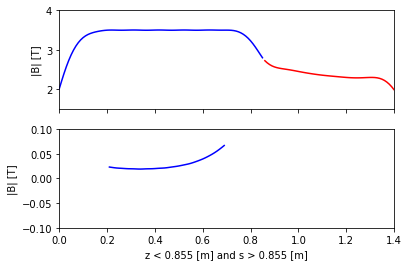

In [52]:
plot_profile(coils)

Print the RMSE over the trap volume:

In [53]:
print(objective_RMSE(coils))

0.005613893815459984


### Differential evolution minimization

Nelder-Mead is a local minimization algorithm and may get stuck in local minima that are not global minima. Differential evolution is a global minimization algorithm that is supposed to bypass that. It is a lot slower, though. We can run with multiple CPUs though, which speads it up a bit.

In [166]:
from scipy.optimize import differential_evolution
res = differential_evolution(objective_arg, bounds = list(bounds.values()),
                             workers = 12, updating = 'immediate', disp = True)
print(res)

differential_evolution step 1: f(x)= 0.0152409
differential_evolution step 2: f(x)= 0.00952075
differential_evolution step 3: f(x)= 0.00437249
differential_evolution step 4: f(x)= 0.00348292
differential_evolution step 5: f(x)= 0.00306932
differential_evolution step 6: f(x)= 0.0024279
differential_evolution step 7: f(x)= 0.00205676
differential_evolution step 8: f(x)= 0.00205676
differential_evolution step 9: f(x)= 0.00205676
differential_evolution step 10: f(x)= 0.00128916
differential_evolution step 11: f(x)= 0.00128916
differential_evolution step 12: f(x)= 0.00128916
differential_evolution step 13: f(x)= 0.00128916
differential_evolution step 14: f(x)= 0.00128916
differential_evolution step 15: f(x)= 0.00128916
differential_evolution step 16: f(x)= 0.00128916
differential_evolution step 17: f(x)= 0.00128916
differential_evolution step 18: f(x)= 0.00128916
differential_evolution step 19: f(x)= 0.00128916
differential_evolution step 20: f(x)= 0.00128916
differential_evolution step 21:

### Gaussian process optimization

We can also use Bayesian optimization design for Gaussian processes. We are not in the case of a Guassian process, so this is not going to work all that well, but it is code I had lying around that I knew worked.

In [167]:
#!pip3 install --user scikit-optimize

from skopt.space import Real, Integer
parameter_space = [Integer(value[0], value[1], name = str(key))
                   if type(value[0]) == int 
                   else Real(value[0], value[1], name = str(key))
                   for value,key in zip(bounds.values(),bounds.keys()) 
                   if value[1] != value[0]]
parameter_names = [key
                   for value,key in zip(bounds.values(),bounds.keys()) 
                   if value[1] != value[0]]

from pprint import pprint
pprint(parameter_space)

[Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=200000.0, high=350000.0, prior='uniform', transform='identity'),
 Real(low=-25000.0, high=

In [168]:
from skopt.utils import use_named_args
@use_named_args(parameter_space)
def objective_function(**kwargs):
    """An objective function to minimize, based on the simulation function to maximize."""
    return objective_kwargs(**kwargs)

noise = None # variance, you may want to change if simulations are noisier than this
random_state = 1234
verbose = True

In [ ]:
from skopt import gp_minimize

try:
    x0 = gp_res.x_iters
    y0 = gp_res.func_vals
    n_random_starts = 0
except NameError:
    x0 = None
    y0 = None
    n_random_starts = 10

gp_res = gp_minimize(
    objective_arg,
    parameter_space,
    acq_func = "gp_hedge", # EI, PI, LCB, or a mixture with gp_hedge
    n_calls = 200,
    n_random_starts = n_random_starts,
    noise = noise,
    x0 = x0,
    y0 = y0,
    random_state = random_state,
    verbose = verbose)

In [160]:
print(gp_res.x, gp_res.fun)

[335134.1070918507, 267977.2350425459, 350000.0, 256094.89270280465, 308913.4259844538, 305203.1754203424, 292677.84272107494, 311873.61779003055, 350000.0, 350000.0, 200199.85957565048, 284836.92005907313, 350000.0, 25000.0, -25000.0, 11008.028078078489, 25000.0, -24356.725079286913, -25000.0, -7887.637790842862, -25000.0] 0.018254400411841645


#### Plot convergence

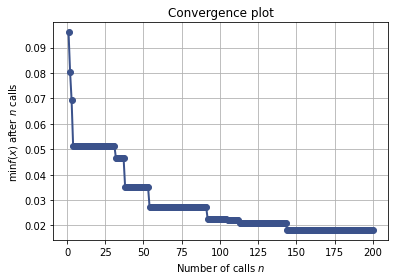

In [168]:
%matplotlib inline
from skopt.plots import plot_convergence
_ = plot_convergence(gp_res);

#### Plot regret

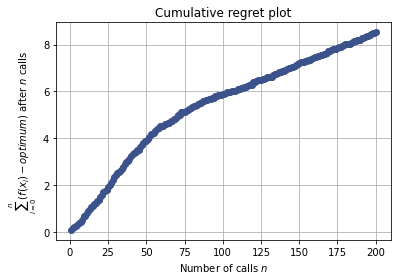

In [169]:
from skopt.plots import plot_regret
_ = plot_regret(gp_res)

#### Plot evaluation matrix

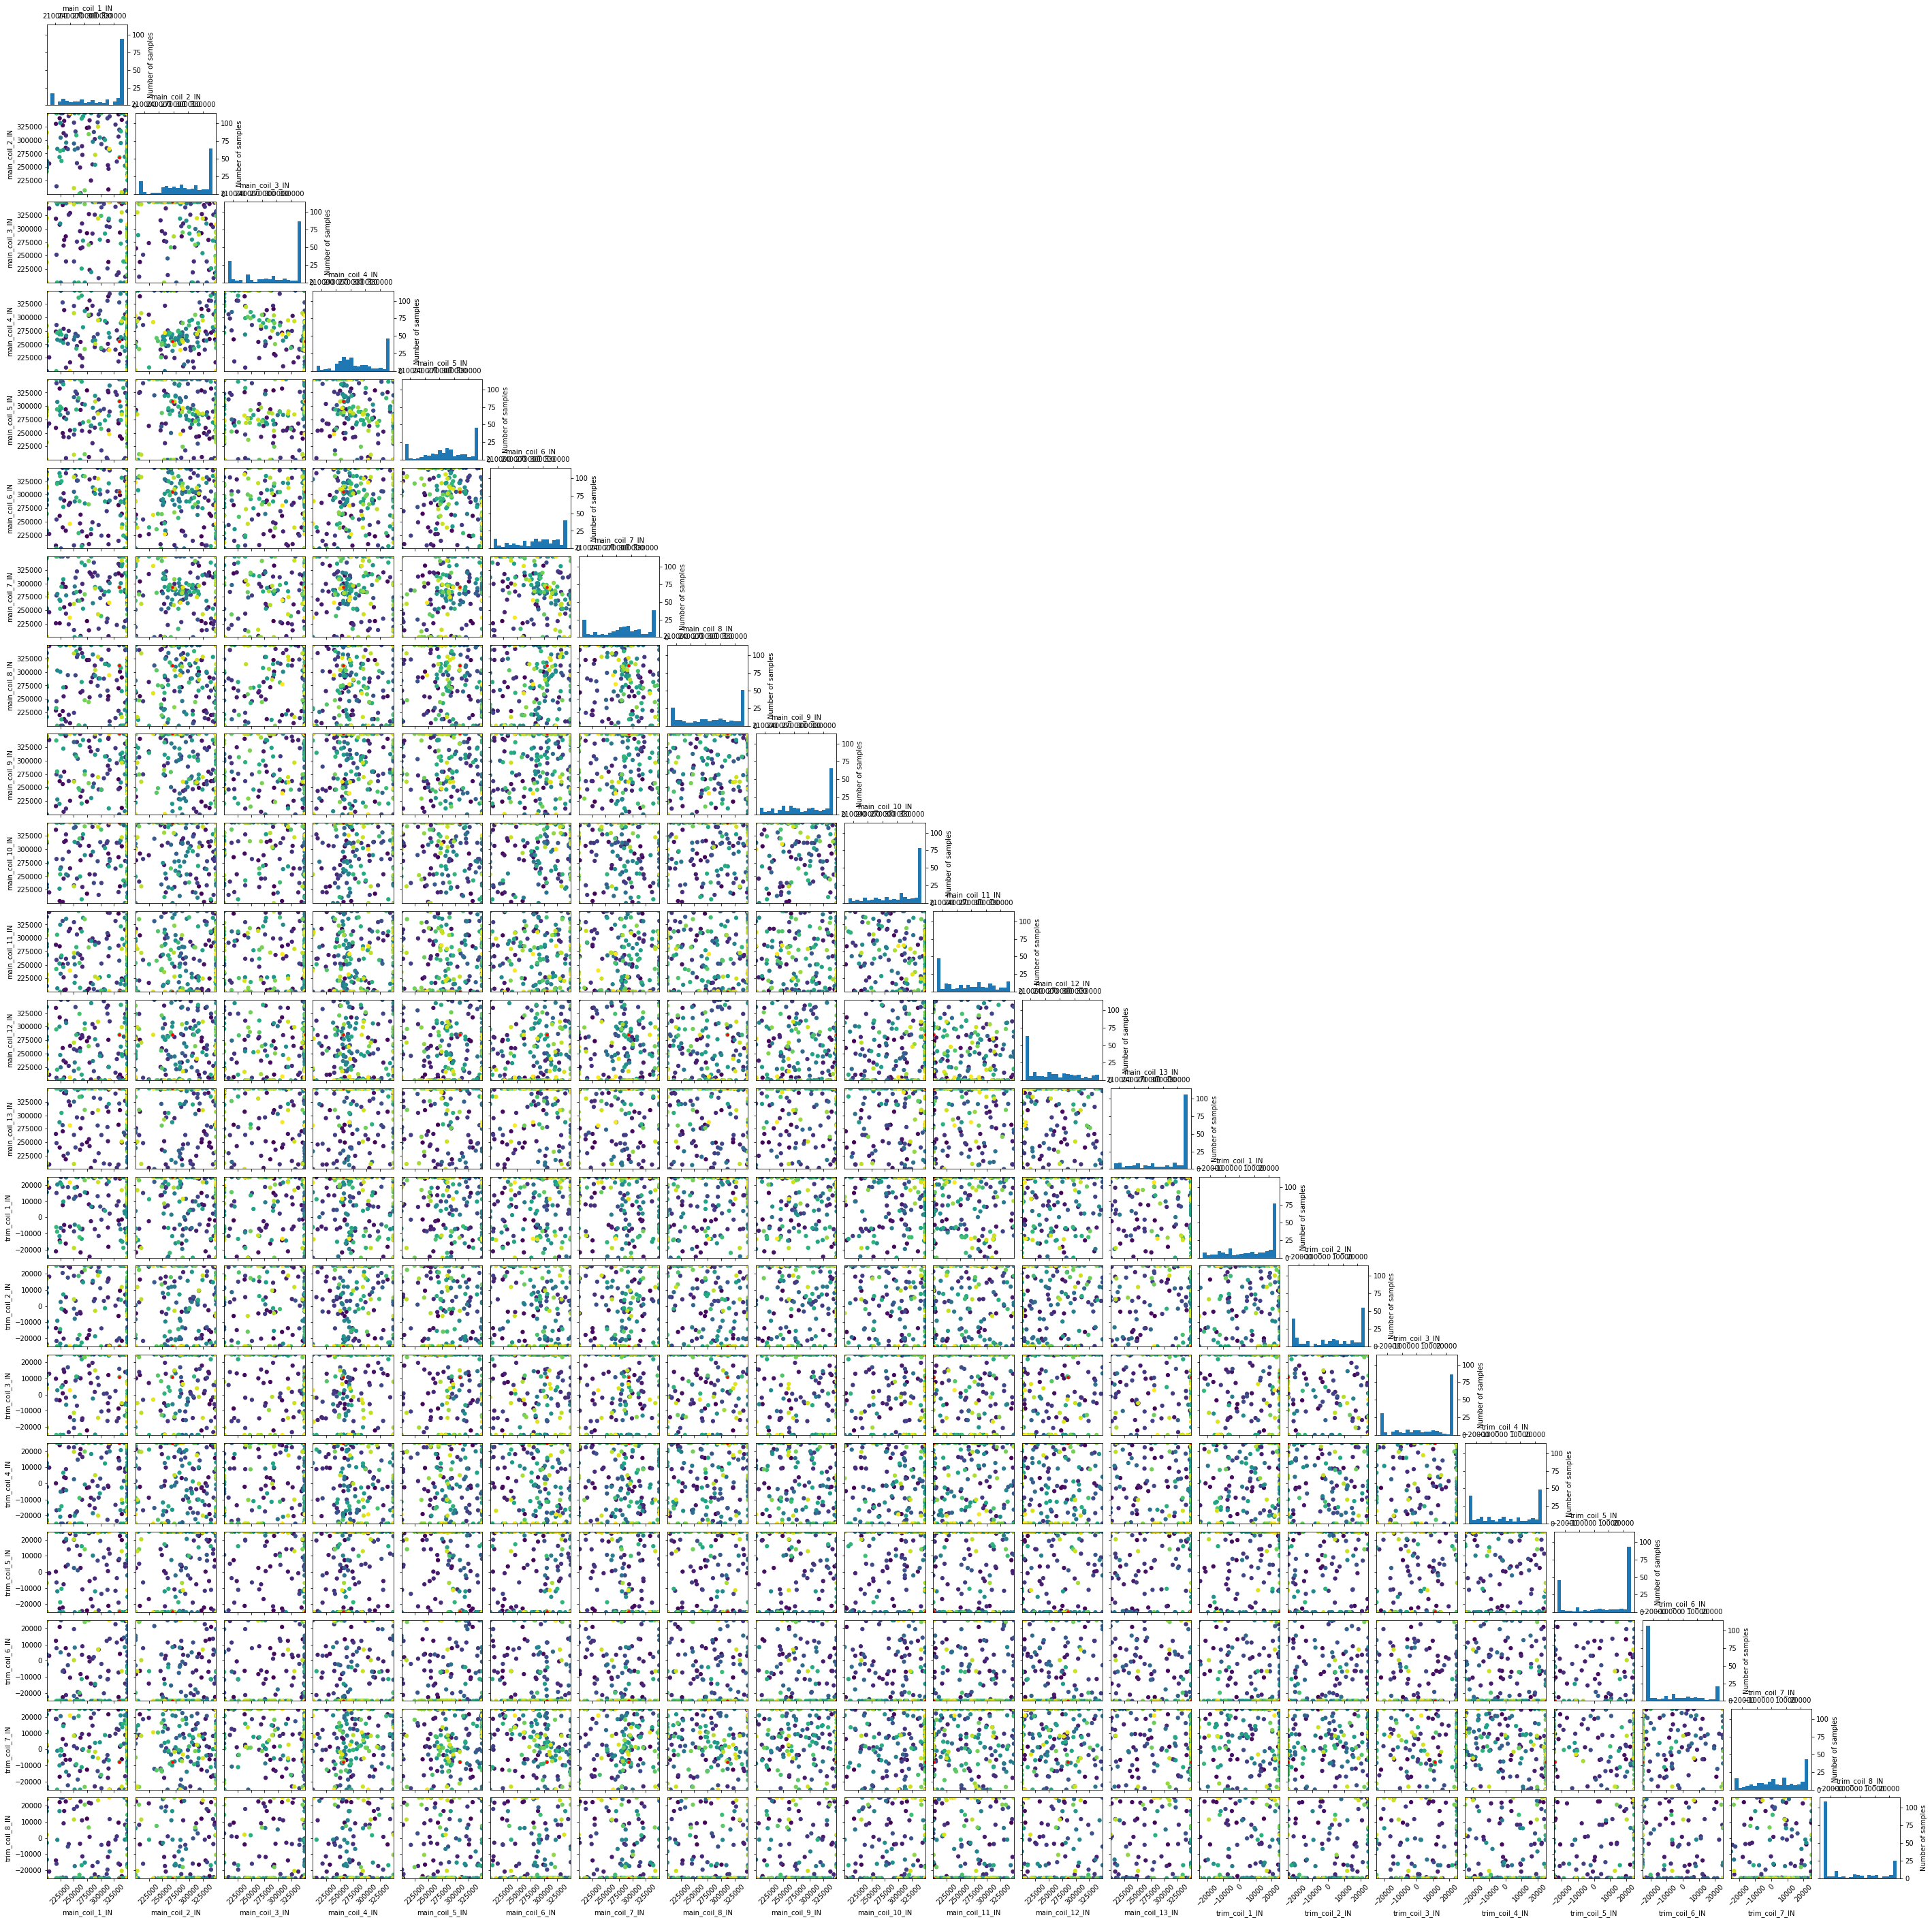

In [170]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(gp_res, dimensions = parameter_names)

#### Plot objective matrix

In [ ]:
from skopt.plots import plot_objective
_ = plot_objective(gp_res, dimensions = parameter_names)